## Import libraries

In [69]:
import numpy as np
import scipy.signal
from tqdm import tqdm
import matplotlib.pyplot as plt
import lab1_tools as tools
import lab1_proto as proto
from sklearn.mixture import GaussianMixture
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data

In [2]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

* **samples**: speech samples for one utterance
* **samplingrate**: sampling rate
* **frames**: speech samples organized in overlapping frames
* **preemph**: pre-emphasized speech samples
* **windowed**: hamming windowed speech samples
* **spec**: squared absolute value of Fast Fourier Transform
* **mspec**: natural log of spec multiplied by Mel filterbank
* **mfcc**: Mel Frequency Cepstrum Coefficients
* **lmfcc**: Liftered Mel Frequency Cepstrum Coefficients

In [3]:
example["samples"].shape

(18432,)

In [4]:
example["samplingrate"]

20000

The files contain the spoken utterances of isolated digits (2 instances each).
The digits are "oh", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine".

In [5]:
data = np.load('lab1_data.npz', allow_pickle=True)["data"]

* **filename**: filename of the wave file in the database
* **samplingrate**: sampling rate of the speech signal (20kHz in all examples)
* **gender**: gender of the speaker for the current utterance (man, woman)
* **speaker**: speaker ID for the current utterance (ae, ac)
* **digit**: digit contained in the current utterance (o, z, 1, ..., 9)
* **repetition**: whether this was the first (a) or second (b) repetition
* **samples**: array of speech samples

## Mel Frequency Cepstrum Coefficients step-by-step

### 4.1 Enframe

Implement the `enframe` function in `lab1_proto.py`.

This will take as input speech samples, the frame length in samples and the number of samples overlap between consecutive frames and outputs a two dimensional array where each row is a frame of samples. Consider only the frames that fit into the original signal disregarding extra samples.

Apply the enframe function to the utterance `example['samples']` with window length of 20 milliseconds and shift of 10 ms (figure out the length and shift in samples from the sampling rate).

In [6]:
computed_enframe = proto.enframe(example['samples'], 400, 200)
## We used the window length and shift to match the example

In [7]:
sample_winlen = int(example["samplingrate"] * 0.02)
sample_winshift = int(example["samplingrate"] * 0.01)
sample_winlen, sample_winshift

(400, 200)

In [8]:
computed_enframe.shape, example['frames'].shape

((91, 400), (91, 400))

Use the `pcolormesh` function from `matplotlib.pyplot` to plot the resulting array. Verify that your result corresponds to the array in `example['frames']`.

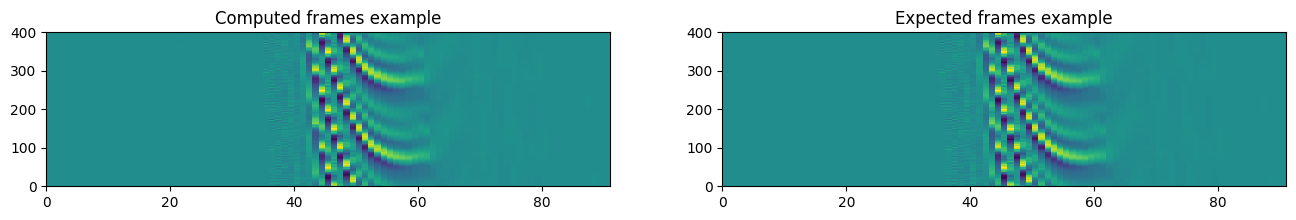

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_enframe.T)
ax[0].set_title('Computed frames example')
ax[1].pcolormesh(example['frames'].T)
ax[1].set_title('Expected frames example')
plt.show()

### 4.2 Pre-emphasis

Implement the `preemp` function in `lab1_proto.py`.

To do this, define a pre-emphasis filter with pre-emphasis coefficient 0.97 using the `lfilter` function from `scipy.signal`.

Explain how you defined the filter coefficients.

We used the function, as followed: `scipy.signal.lfilter([1, -p], 1, input)`
$p$ is the pre-emphasis coefficient. The filter coefficients are $[1, -p]$.
The normalization factor is 1.

Apply the filter to each frame in the output from the `enframe` function. This should correspond to the `example['preemph']` array.

In [10]:
computed_preemp = proto.preemp(computed_enframe, 0.97)

In [11]:
computed_preemp.shape, example['preemph'].shape

((91, 400), (91, 400))

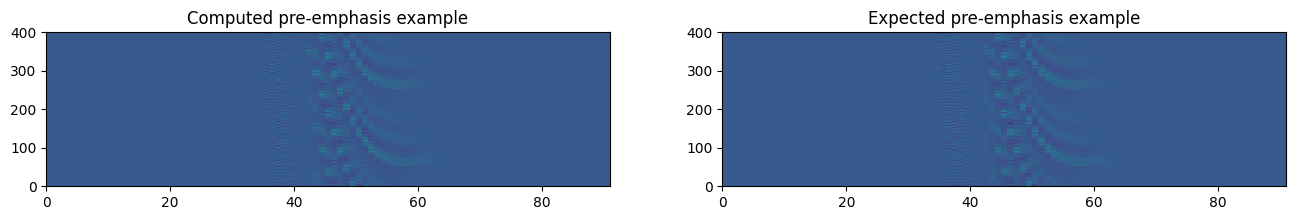

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_preemp.T)
ax[0].set_title('Computed pre-emphasis example')
ax[1].pcolormesh(example['preemph'].T)
ax[1].set_title('Expected pre-emphasis example')
plt.show()

### 4.3 Hamming Window

Implement the `windowing` function in `lab1_proto.py.` 

To do this, define a hamming window of the correct size using the `hamming` function from `scipy.signal` with extra option `sym=False`.

Plot the window shape and explain why this windowing should be applied to the frames of speech signal.

In [13]:
computed_windowed = proto.windowing(computed_preemp)

In [14]:
if hasattr(scipy.signal, 'hamming'):
    hamming_window = scipy.signal.hamming(computed_preemp.shape[1], sym=False)
else:
    hamming_window = scipy.signal.windows.hamming(computed_preemp.shape[1], sym=False)
    
print("Hamming window shape:", hamming_window.shape)

Hamming window shape: (400,)


In [15]:
computed_windowed.shape, example['windowed'].shape

((91, 400), (91, 400))

Apply hamming window to the pre-emphasized frames of the previous step. This should correspond to the `example['windowed']` array.

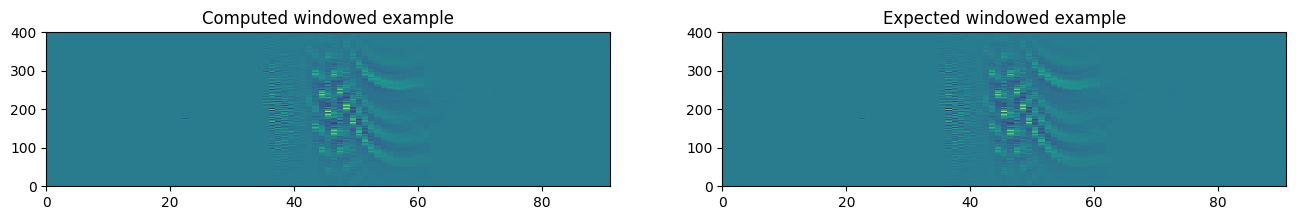

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_windowed.T)
ax[0].set_title('Computed windowed example')
ax[1].pcolormesh(example['windowed'].T)
ax[1].set_title('Expected windowed example')
plt.show()

### 4.4 Fast Fourier Transform

Implement the `powerSpectrum` function in `lab1_proto.py`. To do this, compute the Fast Fourier Transform (FFT) of the input from `scipy.fftpack` and then the squared modulus of the result.

 Apply your function to the windowed speech frames, with FFT length of 512 samples.

In [17]:
computed_spec = proto.powerSpectrum(computed_windowed, 512)

In [18]:
computed_spec.shape, example['spec'].shape

((91, 512), (91, 512))

Plot the resulting power spectrogram with `pcolormesh`. Beware of the fact that the FFT bins correspond to frequencies that go from 0 to fmax and back to 0.

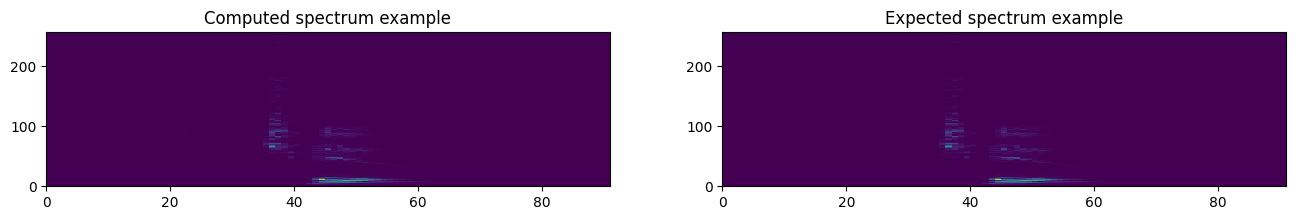

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_spec[:, :len(computed_spec[0])//2].T)
ax[0].set_title('Computed spectrum example')
ax[1].pcolormesh(example['spec'][:, :len(computed_spec[0])//2].T)
ax[1].set_title('Expected spectrum example')
plt.show()

What is fmax in this case according to the Sampling Theorem? The array should correspond to `example['spec']`.

### 4.5 Mel filterbank log spectrum

Implement the `logMelSpectrum` function in `lab1_proto.py`. Use the `trfbank` function, provided in the `lab1_tools.py` file, to create a bank of triangular filters linearly spaced in the Mel frequency scale.

Plot the filters in linear frequency scale.

In [20]:
mel_filters = tools.trfbank(example["samplingrate"], computed_spec.shape[1])

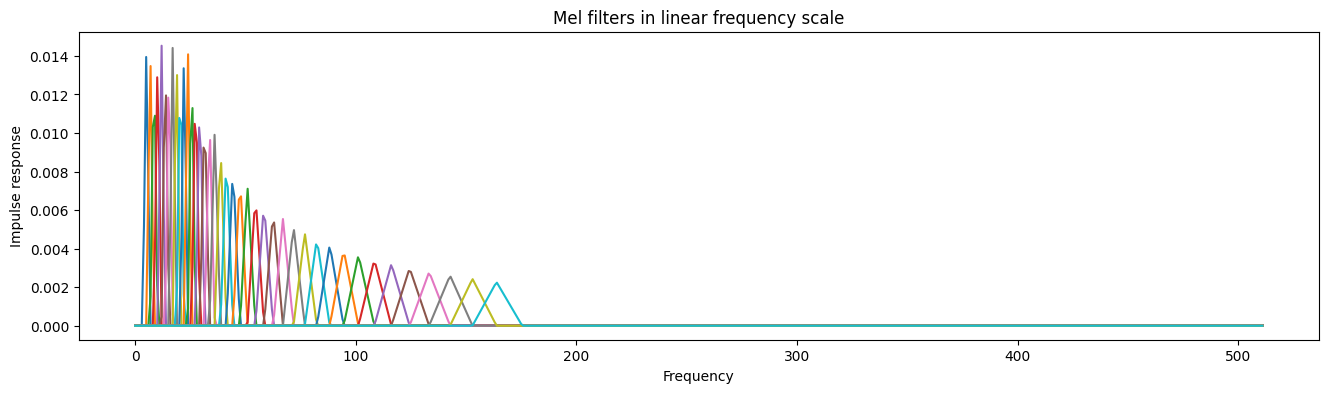

In [21]:
plt.figure(figsize=(16, 4))
for i in range(mel_filters.shape[0]):
    plt.plot(mel_filters[i])
plt.title('Mel filters in linear frequency scale')
plt.xlabel('Frequency')
plt.ylabel('Impulse response')
plt.show()

Describe the distribution of the filters along the frequency axis.

Apply the filters to the output of the power spectrum from the previous step for each frame and take the natural log of the result. Plot the resulting filterbank outputs with `pcolormesh`. This should correspond to the `example['mspec']` array.

In [22]:
computed_mel = proto.logMelSpectrum(computed_spec, example['samplingrate'])

In [23]:
computed_mel.shape, example['mspec'].shape

((91, 40), (91, 40))

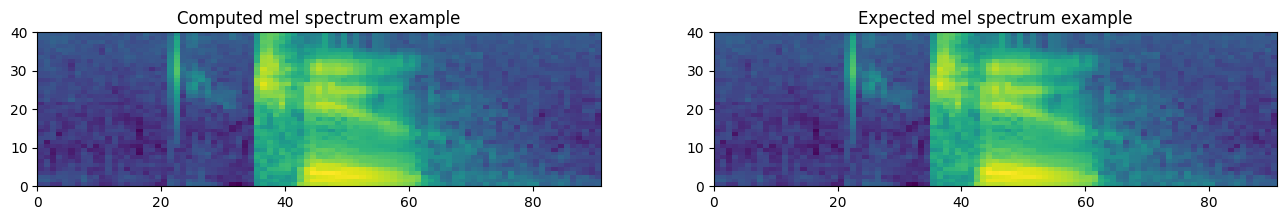

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_mel.T)
ax[0].set_title('Computed mel spectrum example')
ax[1].pcolormesh(example['mspec'].T)
ax[1].set_title('Expected mel spectrum example')
plt.show()

### 4.6 Cosine Transofrm and Liftering

Implement the `cepstrum` function in `lab1_proto.py`. To do this, apply the Discrete Cosine Transform (`dct` function from `scipy.fftpack.realtransforms`) to the outputs of the filterbank.

Use coefficients from 0 to 12 (13 coefficients).

Note that using the $n=13$ input parameter in `dct` is not the same as running without the argument and taking the first 13 elements in the results.

Note that $n=13$ does not only determine the number of output DCT coefficients the function returns, but will also truncate the input in case n is smaller than the input length.

Apply liftering using the function `lifter` in `lab1_tools.py`. This last step is used to correct the range of the coefficients. Plot the resulting coefficients with `pcolormesh`. These should correspond to `example['mfcc']` and `example['lmfcc']` respectively.

In [25]:
computed_mfcc = proto.cepstrum(computed_mel, 13)

In [26]:
computed_mfcc.shape, example['mfcc'].shape

((91, 13), (91, 13))

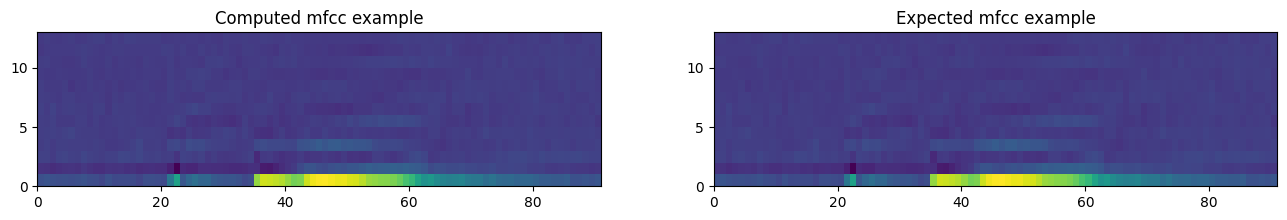

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_mfcc.T)
ax[0].set_title('Computed mfcc example')
ax[1].pcolormesh(example['mfcc'].T)
ax[1].set_title('Expected mfcc example')
plt.show()

In [28]:
computed_lmfcc = tools.lifter(computed_mfcc)

In [29]:
computed_lmfcc.shape, example['lmfcc'].shape

((91, 13), (91, 13))

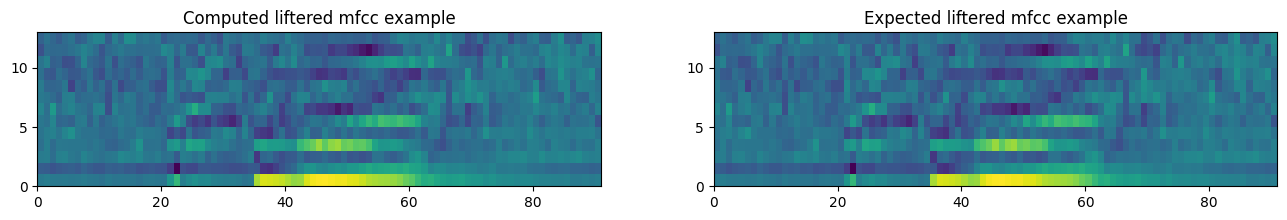

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].pcolormesh(computed_lmfcc.T)
ax[0].set_title('Computed liftered mfcc example')
ax[1].pcolormesh(example['lmfcc'].T)
ax[1].set_title('Expected liftered mfcc example')
plt.show()

Once you are sure all the above steps are correct, use the `mfcc` function (`lab1_proto.py`) to compute the liftered MFCCs for all the utterances in the `data` array.

Observe differences for different utterances.

In [31]:
utterances_names = [f'{data[i]["filename"].split("/")[-1].split(".")[0]}_{data[i]["gender"]}' for i in range(len(data))]
utterances_names[:5]

['oa_man', 'ob_man', 'za_man', 'zb_man', '1a_man']

In [32]:
mfcc_data = {}
for i in range(len(data)):
    sample_name = utterances_names[i]
    sample_winlen = int(data[i]["samplingrate"] * 0.02)
    sample_winshift = int(data[i]["samplingrate"] * 0.01)
    mfcc_data[sample_name] = proto.mfcc(data[i]["samples"], winlen=sample_winlen, winshift=sample_winshift, samplingrate=data[i]["samplingrate"])

## Feature Correlation

Concatenate all the MFCC frames from all utterances in the data array into a big feature $[N ×M]$ array where $N$ is the total number of frames in the data set and $M$ is the number of coefficients.

In [33]:
all_mfccs = np.concatenate([mfcc_data[k] for k in mfcc_data.keys()], axis=0)

In [34]:
all_mfccs.shape

(3885, 13)

Compute the correlation coefficients between features and display the result with pcolormesh.

In [35]:
correlation_matrix_mfcc = np.corrcoef(all_mfccs.T)

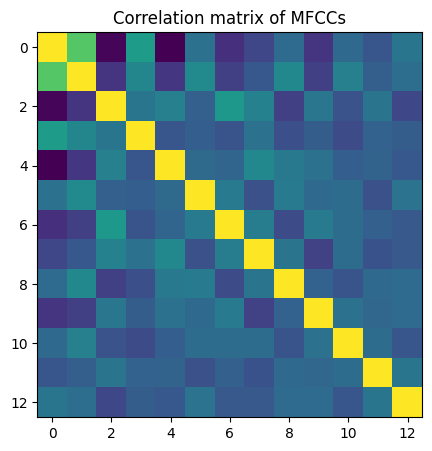

In [36]:
plt.figure(figsize=(5, 5))
plt.imshow(correlation_matrix_mfcc, origin='upper', cmap='viridis')
plt.title('Correlation matrix of MFCCs')
plt.show()

Are features correlated? Is the assumption of diagonal covariance matrices for Gaussian modelling justified?

Compare the results you obtain for the MFCC features with those obtained with the Mel filterbank features (`mspec` features).

In [37]:
mspecs_data = {}
for i in range(len(data)):
    sample_name = utterances_names[i]
    sample_winlen = int(data[i]["samplingrate"] * 0.02)
    sample_winshift = int(data[i]["samplingrate"] * 0.01)
    mspecs_data[sample_name] = proto.mspec(data[i]["samples"], winlen=sample_winlen, winshift=sample_winshift, samplingrate=data[i]["samplingrate"])
all_mspecs = np.concatenate([mspecs_data[k] for k in mspecs_data.keys()], axis=0)
correlation_matrix_mspec = np.corrcoef(all_mspecs.T)

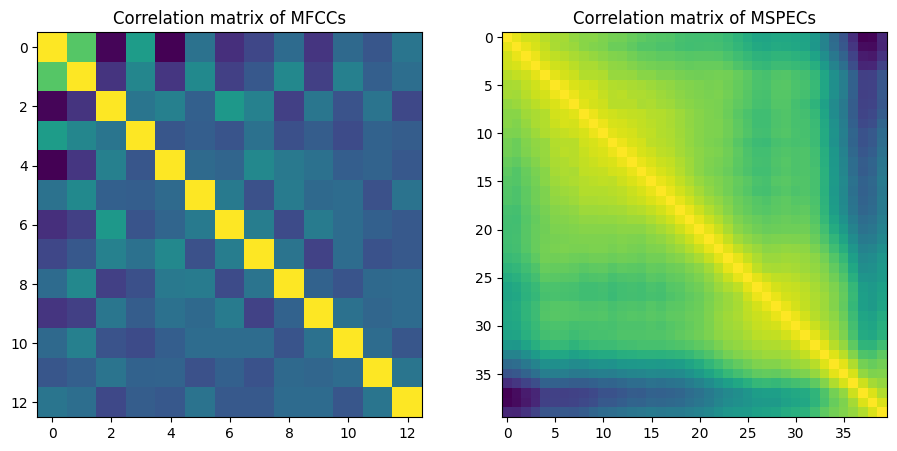

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].imshow(correlation_matrix_mfcc, origin='upper', cmap='viridis', interpolation='none')
ax[0].set_title('Correlation matrix of MFCCs')
ax[1].imshow(correlation_matrix_mspec, origin='upper', cmap='viridis', interpolation='none')
ax[1].set_title('Correlation matrix of MSPECs')
plt.show()

## Explore Speech Segments with Clustering

Using the concatenated data from the previous section, train a Gaussian mixture model with `sklearn.mixture.GMM` (or `sklearn.mixture.GaussianMixture` depending on the version of `sklearn`).

Vary the number of components for example: 4, 8, 16, 32.

In [39]:
gaussian_mixture_models = {}

In [40]:
for i in [4, 6, 7, 8, 16, 32]:
    gaussian_mixture_models[i] = GaussianMixture(n_components=i, random_state=0).fit(all_mfccs)

Once the models are trained, compute GMM posteriors for utterances containing the same words.

In [41]:
posteriors = {}
for i in range(len(data)):
    sample_name =utterances_names[i]
    posteriors[sample_name] = []
    for k in gaussian_mixture_models.keys():
        posteriors[sample_name].append(gaussian_mixture_models[k].score_samples(mfcc_data[sample_name]))

In [42]:
for k in posteriors.keys():
    posteriors[k] = np.array(posteriors[k])

Plot the results with pcolormesh and observe the evolution of the GMM posteriors in time.

In [43]:
labels_components = {}
for k in gaussian_mixture_models.keys():
    labels_components[k] = {}
    labels = gaussian_mixture_models[k].predict(all_mfccs)
    start_position = 0
    for name in utterances_names:
        end_position = start_position + len(mfcc_data[name])
        labels_components[k][name] = labels[start_position:end_position]
        start_position = end_position

In [44]:
all_labels = {}
for k in gaussian_mixture_models.keys():
    all_labels[k] = np.concatenate([labels_components[k][name] for name in utterances_names], axis=0)

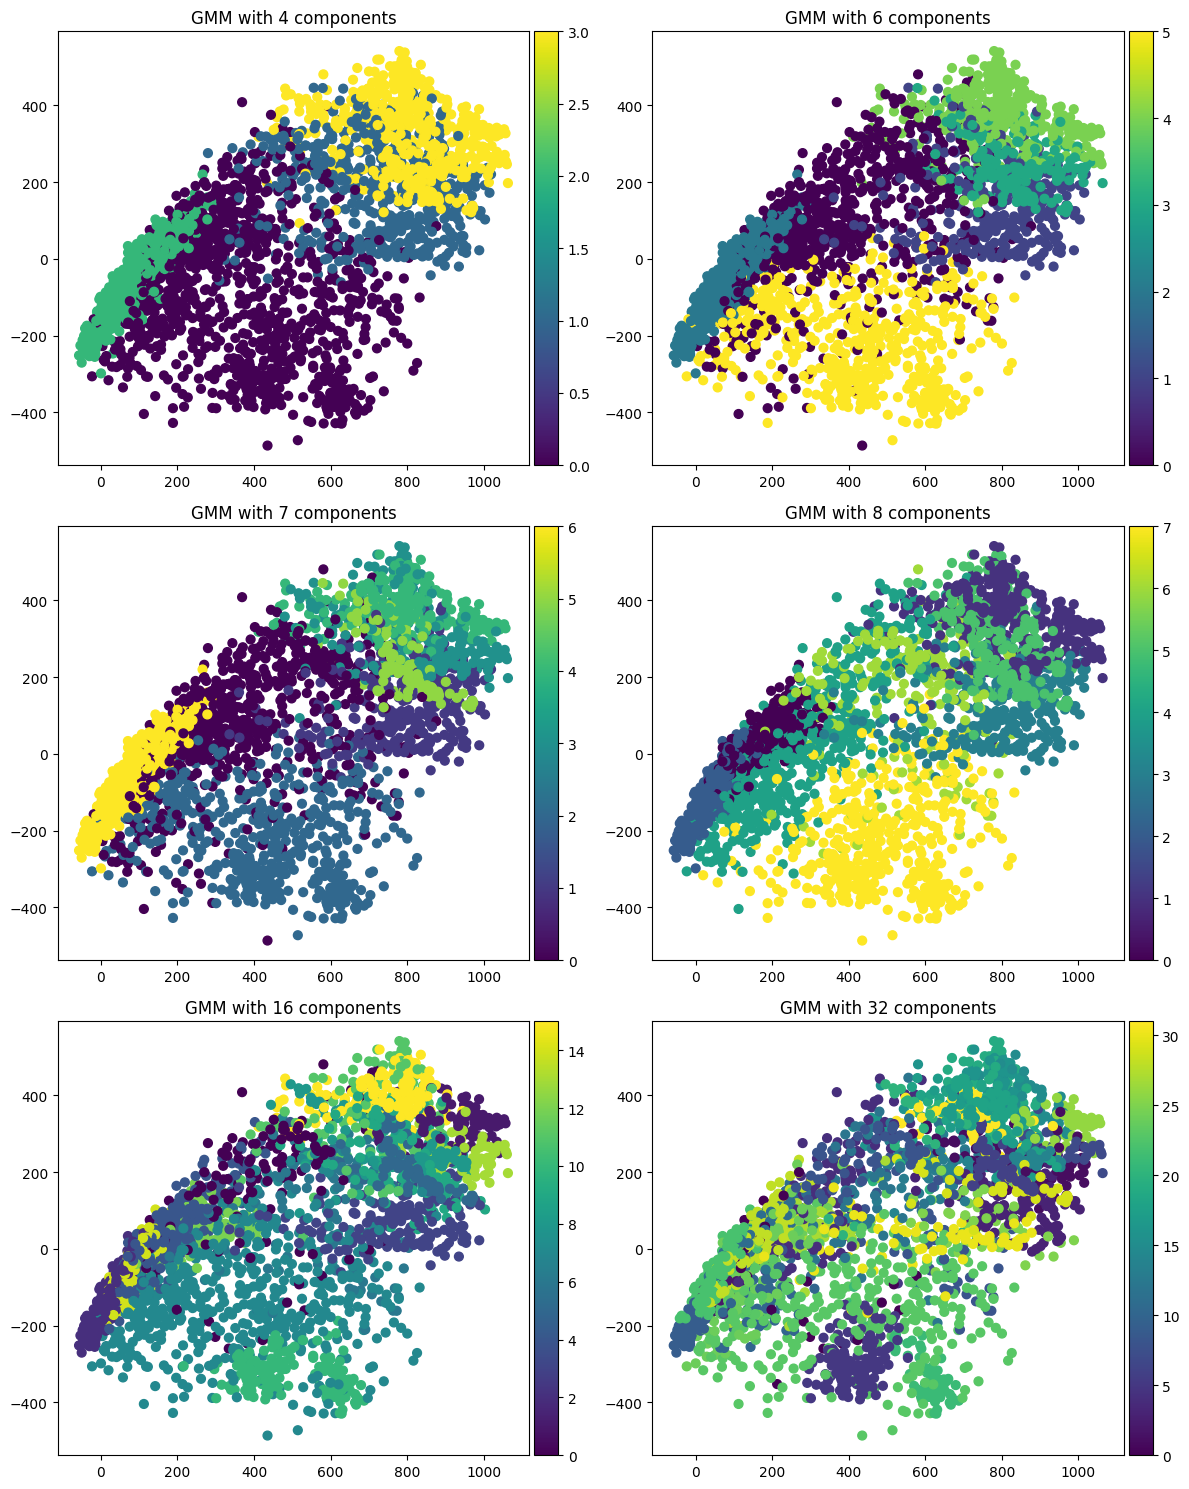

In [45]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))
for i, k in enumerate(gaussian_mixture_models.keys()):
    im = ax[i//2, i%2].scatter(all_mfccs[:, 0], all_mfccs[:, 1], c=all_labels[k], s=40, cmap='viridis')
    ax[i//2, i%2].set_title(f'GMM with {k} components')
    divider = make_axes_locatable(ax[i//2, i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
plt.tight_layout()
plt.show()

* Can you say something about the classes discovered by the unsupervised learning method?
* Do the classes roughly correspond to the phonemes you expect to compose each word?
* Are those classes a stable representation of the word if you compare utterances from different speakers.

As an example, plot and discuss the GMM posteriors for the model with 32 components for the four occurrences of the word “seven” (utterances 16, 17, 38, and 39).

C:\Users\elioc\AppData\Local\Temp\ipykernel_19836\3197262622.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 12 Axes> than <Figure size 1600x900 with 5 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
C:\Users\elioc\AppData\Local\Temp\ipykernel_19836\3197262622.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 12 Axes> than <Figure size 1600x900 with 6 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
C:\Users\elioc\AppData\Local\Temp\ipykernel_19836\3197262622.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 12 Axes> than <Figure size 1600x900 with 7 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cax, orientation='vertical')
C:\Users\elioc\AppData\Local\Temp\ipykernel_19836\3197262622.py:25: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1500 with 12 Axes> th

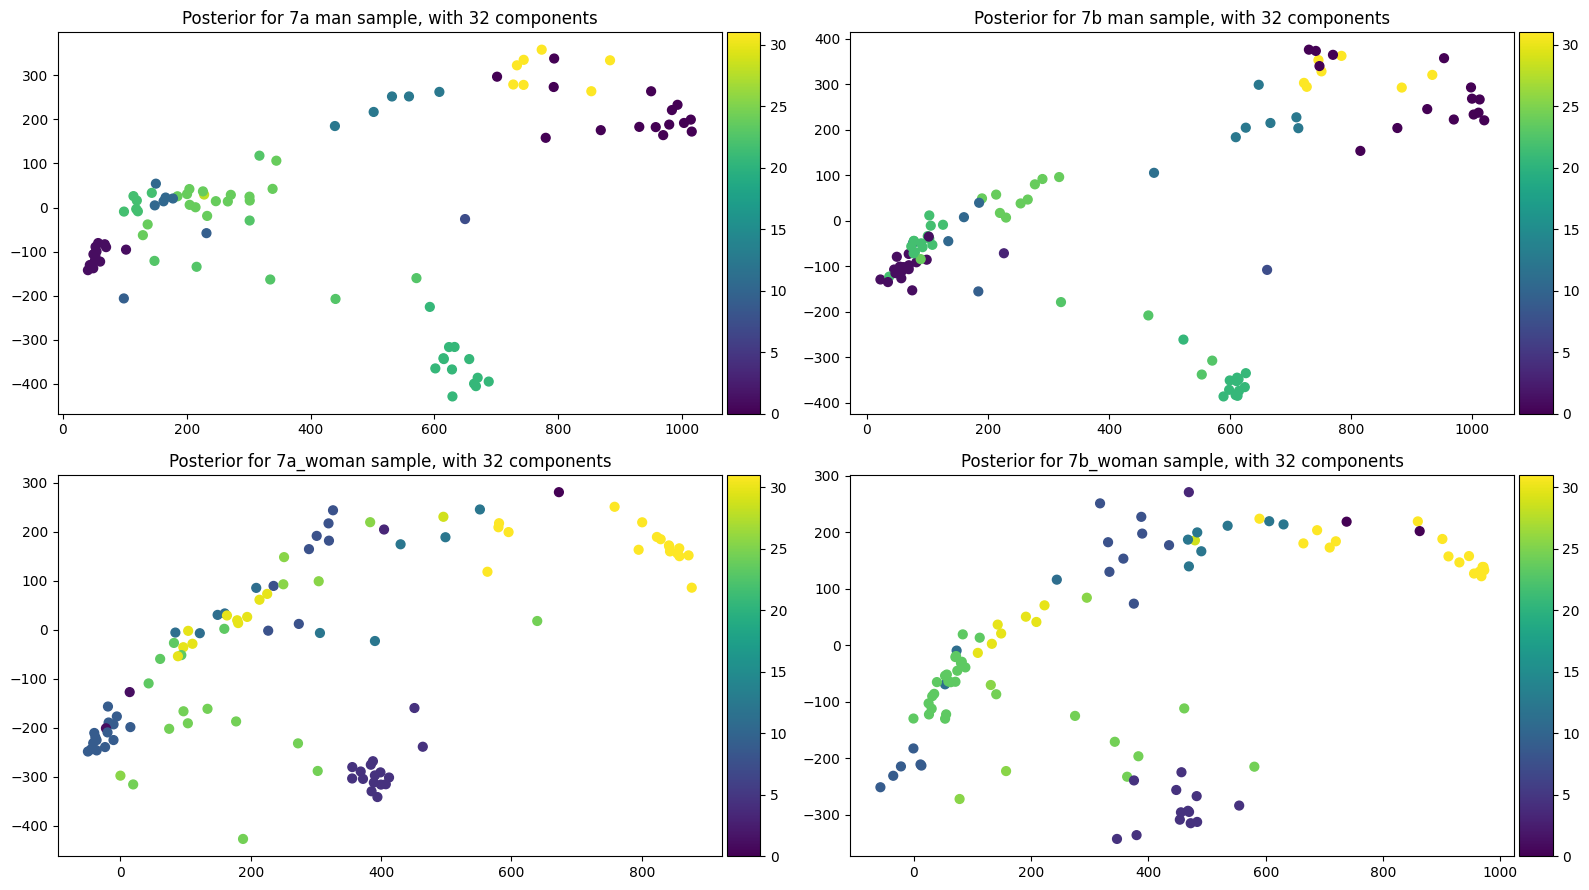

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].scatter(mfcc_data["7a_man"][:, 0], mfcc_data["7a_man"][:, 1], c=labels_components[32]["7a_man"], s=40, cmap='viridis')
ax[0, 0].set_title('Posterior for 7a man sample, with 32 components')
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax[0, 1].scatter(mfcc_data["7b_man"][:, 0], mfcc_data["7b_man"][:, 1], c=labels_components[32]["7b_man"], s=40, cmap='viridis')
ax[0, 1].set_title('Posterior for 7b man sample, with 32 components')
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax[1, 0].scatter(mfcc_data["7a_woman"][:, 0], mfcc_data["7a_woman"][:, 1], c=labels_components[32]["7a_woman"], s=40, cmap='viridis')
ax[1, 0].set_title('Posterior for 7a_woman sample, with 32 components')
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax[1, 1].scatter(mfcc_data["7b_woman"][:, 0], mfcc_data["7b_woman"][:, 1], c=labels_components[32]["7b_woman"], s=40, cmap='viridis')
ax[1, 1].set_title('Posterior for 7b_woman sample, with 32 components')
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [47]:
nb_components2idx = {4: 0, 6: 1, 7: 2, 8: 3, 16: 4, 32: 5}

In [48]:
def plot_posteriors(number = 7, nb_components = 32):
    fig, ax = plt.subplots(2, 2, figsize=(16, 9))

    ax[0, 0].pcolormesh(posteriors[f"{number}a_man"][nb_components2idx[nb_components]].reshape(1, -1))
    ax[0, 0].set_title(f'Posterior for {number}a man sample, with {nb_components} components')
    ax[0, 0].set_xlabel('Frames')

    ax[0, 1].pcolormesh(posteriors[f"{number}b_man"][nb_components2idx[nb_components]].reshape(1, -1))
    ax[0, 1].set_title(f'Posterior for {number}b man sample, with {nb_components} components')
    ax[0, 1].set_xlabel('Frames')

    ax[1, 0].pcolormesh(posteriors[f"{number}a_woman"][nb_components2idx[nb_components]].reshape(1, -1))
    ax[1, 0].set_title(f'Posterior for {number}a woman sample, with {nb_components} components')
    ax[1, 0].set_xlabel('Frames')

    im = ax[1, 1].pcolormesh(posteriors[f"{number}b_woman"][nb_components2idx[nb_components]].reshape(1, -1))
    ax[1, 1].set_title(f'Posterior for {number}b woman sample, with {nb_components} components')
    ax[1, 1].set_xlabel('Frames')

    cbar_ax = fig.add_axes([0.925, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()

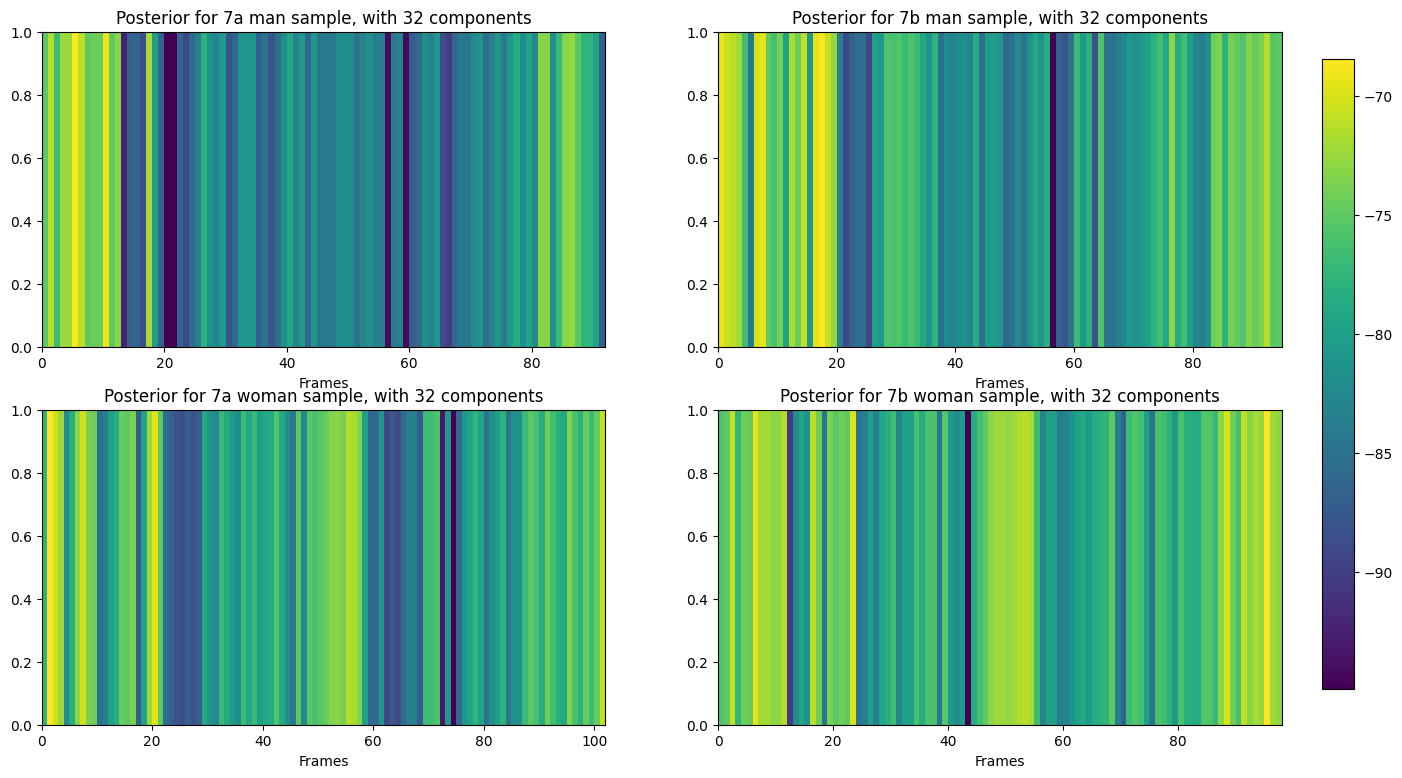

In [49]:
plot_posteriors()

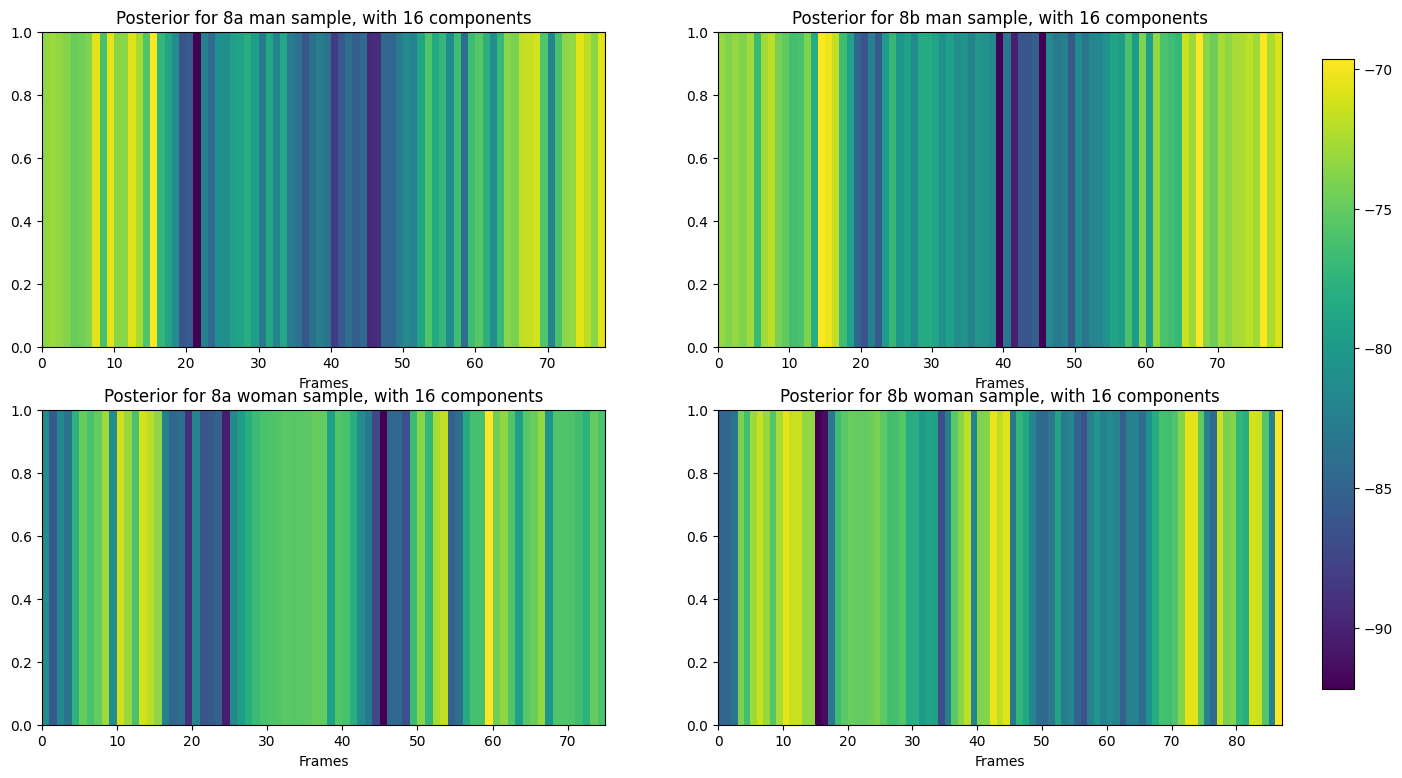

In [50]:
plot_posteriors(number=8, nb_components=16)

## Comparing Utterances

Given two utterances of length $N$ and $M$ respectively, compute an $[N × M]$ matrix of local Euclidean distances between each MFCC vector in the first utterance and each MFCC vector in the second utterance.

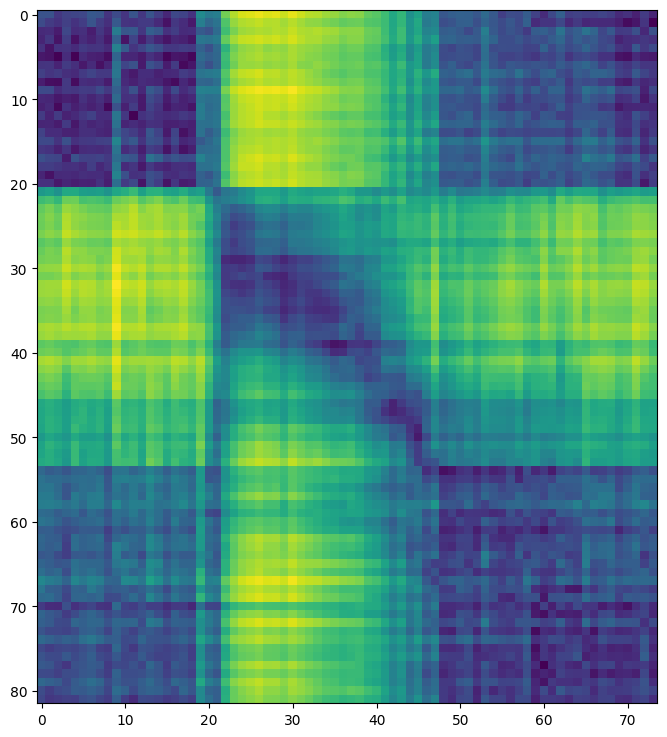

In [51]:
idx1 = 0
idx2 = 1

sample1 = mfcc_data[utterances_names[idx1]]
sample2 = mfcc_data[utterances_names[idx2]]

distances = scipy.spatial.distance.cdist(sample1, sample2, metric='euclidean')

plt.figure(figsize=(8, 9))
plt.imshow(distances, origin='upper', cmap='viridis', aspect='auto')


Write a function called `dtw` (`lab1_proto.py`) that takes as input this matrix of local distances and outputs the result of the Dynamic Time Warping algorithm. The main output is the global distance between the two sequences (utterances), but you may want to output also the best path for debugging reasons.

In [53]:
d, LD, AD, path = proto.dtw(sample1, sample2, distances)

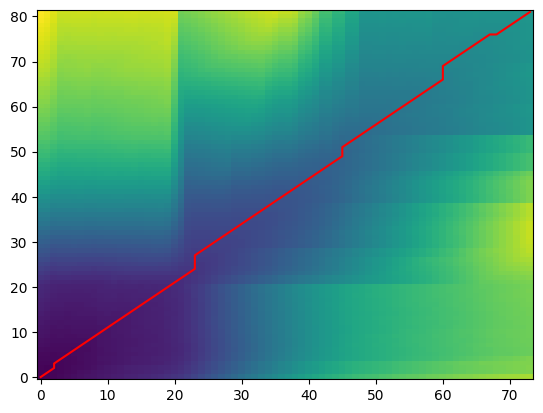

In [61]:
plt.imshow(AD, origin='lower', cmap='viridis', aspect='auto')
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], color='r')

For each pair of utterances in the data array:

1. compute the local Euclidean distances between MFCC vectors in the first and second utterance
2. compute the global distance between utterances with the `dtw` function you have written

In [73]:
local_dist = [[[] for _ in range(len(utterances_names))] for _ in range(len(utterances_names))]
D = np.zeros((len(utterances_names), len(utterances_names)))
                       
for i in tqdm(range(len(utterances_names))):
    for j in range(len(utterances_names)):
        dist =  scipy.spatial.distance.cdist(
            mfcc_data[utterances_names[i]], mfcc_data[utterances_names[j]], metric='euclidean')
        local_dist[i][j] = dist
        d, LD, AD, path = proto.dtw(mfcc_data[utterances_names[i]], mfcc_data[utterances_names[j]], local_dist[i][j])
        D[i, j] = d

100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


Store the global pairwise distances in a matrix $D$ $(44×44)$.
Display the matrix with `pcolormesh`.

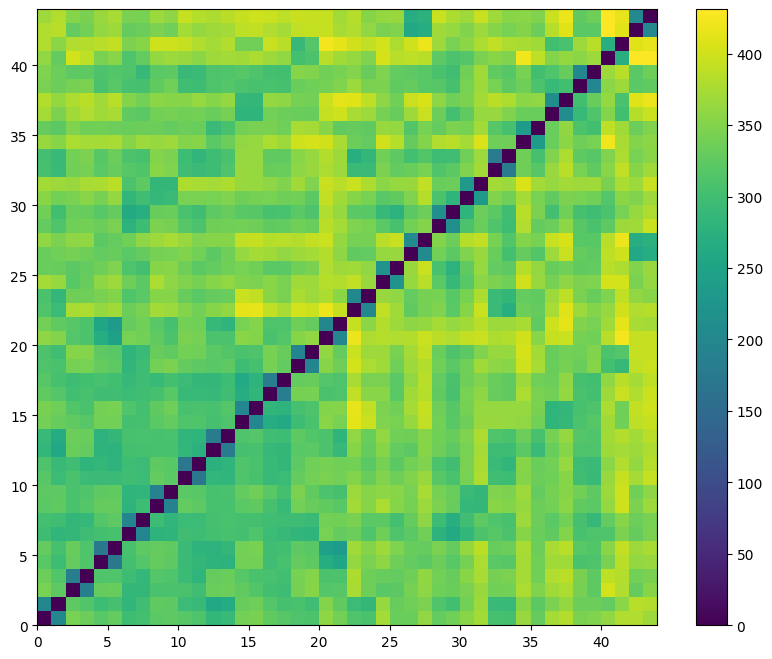

In [74]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(D)
plt.colorbar()

Compare distances within the same digit and across different digits.
Does the distance separate digits well even between different speakers?

Run hierarchical clustering on the distance matrix $D$ using the `linkage` function from `scipy.cluster` hierarchy.
Use the ”complete” linkage method.

Display the results with the function `dendrogram` from the same library, and comment them.
Use the `tidigit2labels` function (`lab1_tools.py`) to create labels to add to the dendrogram to simplify the interpretation of the results.